In [1]:
import pickle
import torch
import copy
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torchsummary

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
torch.cuda.is_available()

CUDA is available!  Training on GPU ...


True

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=42
BATCH_SIZE=64

SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_list = []
        transform_list.append(transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)))
        if self.mode != 'test':            
            transform_list.append(transforms.RandomHorizontalFlip())
            transform_list.append(transforms.RandomRotation(15))
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]))
        
        transform = transforms.Compose(transform_list)
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [4]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [5]:
def create_dct_path_labels(train_val_files, train_val_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_val_files, train_val_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [6]:
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)
print(len(train_val_files))

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
train_val_files = []
for person in dct_path_train:
    train_val_files.extend(dct_path_train[person])
print(len(train_val_files))

train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

20933
21887


In [7]:
class SimpsonCNN(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        # 224
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 110
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop1 = nn.Dropout2d(p=0.25)
        # 54
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 26
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop2 = nn.Dropout2d(p=0.25)
        # 12
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 5        
        self.fc1 = nn.Sequential(
            nn.Linear(5 * 5 * 256, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.drop3 = nn.Dropout2d(p=0.25)
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.out = nn.Linear(1024, n_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform_(m.weight.data,gain=nn.init.calculate_gain('relu'))

    def forward(self, x):
        x = self.conv1(x)
        x = self.drop1(self.conv2(x))
        x = self.conv3(x)
        x = self.drop2(self.conv4(x))
        x = self.conv5(x)
        x = x.view(-1, 5 * 5 * 256)
        x = self.drop3(self.fc1(x))        
        x = self.fc2(x)        
        logits = self.out(x)
        return logits

In [8]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode='max', factor=0.1, patience=3, verbose=False)
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step(val_acc)
                
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [9]:
n_classes = len(np.unique(train_val_labels))
clf = SimpsonCNN(n_classes).to(DEVICE)
torchsummary.summary(clf.cuda(), (3, RESCALE_SIZE, RESCALE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 220, 220]           2,432
              ReLU-2         [-1, 32, 220, 220]               0
         MaxPool2d-3         [-1, 32, 110, 110]               0
            Conv2d-4         [-1, 32, 108, 108]           9,248
              ReLU-5         [-1, 32, 108, 108]               0
         MaxPool2d-6           [-1, 32, 54, 54]               0
         Dropout2d-7           [-1, 32, 54, 54]               0
            Conv2d-8           [-1, 64, 52, 52]          18,496
              ReLU-9           [-1, 64, 52, 52]               0
        MaxPool2d-10           [-1, 64, 26, 26]               0
           Conv2d-11          [-1, 128, 24, 24]          73,856
             ReLU-12          [-1, 128, 24, 24]               0
        MaxPool2d-13          [-1, 128, 12, 12]               0
        Dropout2d-14          [-1, 128,

epoch:   0%|                                                                                    | 0/42 [00:00<?, ?it/s]

loss 2.9737907854406127


epoch:   2%|█▋                                                                       | 1/42 [02:57<2:00:59, 177.05s/it]


Epoch 001 train_loss: 2.9738     val_loss 2.2633 train_acc 0.2163 val_acc 0.3847
loss 1.9665822764050114


epoch:   5%|███▍                                                                     | 2/42 [04:15<1:38:14, 147.37s/it]


Epoch 002 train_loss: 1.9666     val_loss 1.6294 train_acc 0.4571 val_acc 0.5316
loss 1.3054826877990802


epoch:   7%|█████▏                                                                   | 3/42 [05:29<1:21:35, 125.52s/it]


Epoch 003 train_loss: 1.3055     val_loss 1.2921 train_acc 0.6274 val_acc 0.6402
loss 0.9250008533177418


epoch:  10%|██████▉                                                                  | 4/42 [06:48<1:10:40, 111.60s/it]


Epoch 004 train_loss: 0.9250     val_loss 0.8901 train_acc 0.7362 val_acc 0.7460
loss 0.6741952123745091


epoch:  12%|████████▋                                                                | 5/42 [08:10<1:03:17, 102.65s/it]


Epoch 005 train_loss: 0.6742     val_loss 0.8561 train_acc 0.8035 val_acc 0.7569
loss 0.49360757802558897


epoch:  14%|██████████▊                                                                 | 6/42 [09:30<57:24, 95.68s/it]


Epoch 006 train_loss: 0.4936     val_loss 0.7408 train_acc 0.8565 val_acc 0.7966
loss 0.3813485968741127


epoch:  17%|████████████▋                                                               | 7/42 [10:50<53:10, 91.15s/it]


Epoch 007 train_loss: 0.3813     val_loss 0.6616 train_acc 0.8850 val_acc 0.8224
loss 0.29954909435540045


epoch:  19%|██████████████▍                                                             | 8/42 [12:09<49:38, 87.59s/it]


Epoch 008 train_loss: 0.2995     val_loss 0.7233 train_acc 0.9078 val_acc 0.8158
loss 0.22093476574122453


epoch:  21%|████████████████▎                                                           | 9/42 [13:28<46:43, 84.95s/it]


Epoch 009 train_loss: 0.2209     val_loss 0.7638 train_acc 0.9338 val_acc 0.8107
loss 0.20855624979311396


epoch:  24%|█████████████████▊                                                         | 10/42 [14:47<44:17, 83.03s/it]


Epoch 010 train_loss: 0.2086     val_loss 0.6408 train_acc 0.9351 val_acc 0.8416
loss 0.15750064078969198


epoch:  26%|███████████████████▋                                                       | 11/42 [16:05<42:09, 81.60s/it]


Epoch 011 train_loss: 0.1575     val_loss 0.6680 train_acc 0.9511 val_acc 0.8434
loss 0.13821900310610402


epoch:  29%|█████████████████████▍                                                     | 12/42 [17:27<40:52, 81.76s/it]


Epoch 012 train_loss: 0.1382     val_loss 0.6753 train_acc 0.9574 val_acc 0.8536
loss 0.11999256801946095


epoch:  31%|███████████████████████▏                                                   | 13/42 [18:48<39:25, 81.55s/it]


Epoch 013 train_loss: 0.1200     val_loss 0.6751 train_acc 0.9645 val_acc 0.8481
loss 0.1124200386805684


epoch:  33%|█████████████████████████                                                  | 14/42 [20:09<38:01, 81.47s/it]


Epoch 014 train_loss: 0.1124     val_loss 0.6878 train_acc 0.9669 val_acc 0.8553
loss 0.11840120490417429


epoch:  36%|██████████████████████████▊                                                | 15/42 [21:28<36:13, 80.51s/it]


Epoch 015 train_loss: 0.1184     val_loss 0.6974 train_acc 0.9640 val_acc 0.8507
loss 0.09242412267642013


epoch:  38%|████████████████████████████▌                                              | 16/42 [22:51<35:13, 81.30s/it]


Epoch 016 train_loss: 0.0924     val_loss 0.6957 train_acc 0.9718 val_acc 0.8642
loss 0.0883716961173179


epoch:  40%|██████████████████████████████▎                                            | 17/42 [24:20<34:54, 83.78s/it]


Epoch 017 train_loss: 0.0884     val_loss 0.6992 train_acc 0.9722 val_acc 0.8575
loss 0.08774418726114104


epoch:  43%|████████████████████████████████▏                                          | 18/42 [25:49<34:05, 85.22s/it]


Epoch 018 train_loss: 0.0877     val_loss 0.7969 train_acc 0.9745 val_acc 0.8481
loss 0.07946353426229798


epoch:  45%|█████████████████████████████████▉                                         | 19/42 [27:15<32:46, 85.50s/it]


Epoch 019 train_loss: 0.0795     val_loss 0.7397 train_acc 0.9741 val_acc 0.8575
loss 0.06878737049279982


epoch:  48%|███████████████████████████████████▋                                       | 20/42 [28:49<32:15, 87.98s/it]


Epoch 020 train_loss: 0.0688     val_loss 0.7869 train_acc 0.9784 val_acc 0.8562
loss 0.028822664686961215


epoch:  50%|█████████████████████████████████████▌                                     | 21/42 [30:16<30:43, 87.80s/it]


Epoch 021 train_loss: 0.0288     val_loss 0.6270 train_acc 0.9903 val_acc 0.8829
loss 0.013551091117727078


epoch:  52%|███████████████████████████████████████▎                                   | 22/42 [31:41<28:59, 86.96s/it]


Epoch 022 train_loss: 0.0136     val_loss 0.6118 train_acc 0.9964 val_acc 0.8865
loss 0.010027130950771913


epoch:  55%|█████████████████████████████████████████                                  | 23/42 [33:05<27:11, 85.84s/it]


Epoch 023 train_loss: 0.0100     val_loss 0.6410 train_acc 0.9974 val_acc 0.8834
loss 0.00710149640692588


epoch:  57%|██████████████████████████████████████████▊                                | 24/42 [34:29<25:39, 85.51s/it]


Epoch 024 train_loss: 0.0071     val_loss 0.6091 train_acc 0.9982 val_acc 0.8904
loss 0.0060360007848167365


epoch:  60%|████████████████████████████████████████████▋                              | 25/42 [35:54<24:10, 85.30s/it]


Epoch 025 train_loss: 0.0060     val_loss 0.6134 train_acc 0.9985 val_acc 0.8904
loss 0.006241512516444284


epoch:  62%|██████████████████████████████████████████████▍                            | 26/42 [37:16<22:27, 84.20s/it]


Epoch 026 train_loss: 0.0062     val_loss 0.6129 train_acc 0.9988 val_acc 0.8878
loss 0.004117884651901727


epoch:  64%|████████████████████████████████████████████████▏                          | 27/42 [38:38<20:54, 83.62s/it]


Epoch 027 train_loss: 0.0041     val_loss 0.6136 train_acc 0.9992 val_acc 0.8946
loss 0.0037848481890843545


epoch:  67%|██████████████████████████████████████████████████                         | 28/42 [40:03<19:38, 84.19s/it]


Epoch 028 train_loss: 0.0038     val_loss 0.6246 train_acc 0.9990 val_acc 0.8913
loss 0.0028700039593518197


epoch:  69%|███████████████████████████████████████████████████▊                       | 29/42 [41:26<18:06, 83.60s/it]


Epoch 029 train_loss: 0.0029     val_loss 0.6423 train_acc 0.9993 val_acc 0.8861
loss 0.003811296195182138


epoch:  71%|█████████████████████████████████████████████████████▌                     | 30/42 [42:49<16:41, 83.46s/it]


Epoch 030 train_loss: 0.0038     val_loss 0.6449 train_acc 0.9990 val_acc 0.8898
loss 0.002706353939618482


epoch:  74%|███████████████████████████████████████████████████████▎                   | 31/42 [44:13<15:20, 83.66s/it]


Epoch 031 train_loss: 0.0027     val_loss 0.6569 train_acc 0.9993 val_acc 0.8893
loss 0.0030314038230661966


epoch:  76%|█████████████████████████████████████████████████████████▏                 | 32/42 [45:39<14:02, 84.28s/it]


Epoch 032 train_loss: 0.0030     val_loss 0.6760 train_acc 0.9993 val_acc 0.8880
loss 0.002154054069468037


epoch:  79%|██████████████████████████████████████████████████████████▉                | 33/42 [47:07<12:48, 85.36s/it]


Epoch 033 train_loss: 0.0022     val_loss 0.6448 train_acc 0.9994 val_acc 0.8907
loss 0.002618877109942406


epoch:  81%|████████████████████████████████████████████████████████████▋              | 34/42 [48:32<11:23, 85.48s/it]


Epoch 034 train_loss: 0.0026     val_loss 0.6605 train_acc 0.9991 val_acc 0.8904
loss 0.0020626493681070715


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 35/42 [49:50<09:42, 83.27s/it]


Epoch 035 train_loss: 0.0021     val_loss 0.6491 train_acc 0.9993 val_acc 0.8898
loss 0.0019996998915067237


epoch:  86%|████████████████████████████████████████████████████████████████▎          | 36/42 [51:05<08:03, 80.62s/it]


Epoch 036 train_loss: 0.0020     val_loss 0.6610 train_acc 0.9995 val_acc 0.8904
loss 0.0015541209703844785


epoch:  88%|██████████████████████████████████████████████████████████████████         | 37/42 [52:20<06:34, 78.97s/it]


Epoch 037 train_loss: 0.0016     val_loss 0.6313 train_acc 0.9997 val_acc 0.8964
loss 0.0016336553749679995


epoch:  90%|███████████████████████████████████████████████████████████████████▊       | 38/42 [53:35<05:11, 77.88s/it]


Epoch 038 train_loss: 0.0016     val_loss 0.6620 train_acc 0.9995 val_acc 0.8916
loss 0.002161434573297951


epoch:  93%|█████████████████████████████████████████████████████████████████████▋     | 39/42 [54:55<03:55, 78.41s/it]


Epoch 039 train_loss: 0.0022     val_loss 0.6485 train_acc 0.9995 val_acc 0.8913
loss 0.00133099455761993


epoch:  95%|███████████████████████████████████████████████████████████████████████▍   | 40/42 [56:23<02:42, 81.16s/it]


Epoch 040 train_loss: 0.0013     val_loss 0.6313 train_acc 0.9997 val_acc 0.8973
loss 0.0012782365564461724


epoch:  98%|█████████████████████████████████████████████████████████████████████████▏ | 41/42 [57:49<01:22, 82.68s/it]


Epoch 041 train_loss: 0.0013     val_loss 0.6400 train_acc 0.9998 val_acc 0.8936
loss 0.0011294595867712698


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 42/42 [59:10<00:00, 84.54s/it]


Epoch 042 train_loss: 0.0011     val_loss 0.6561 train_acc 0.9998 val_acc 0.8942


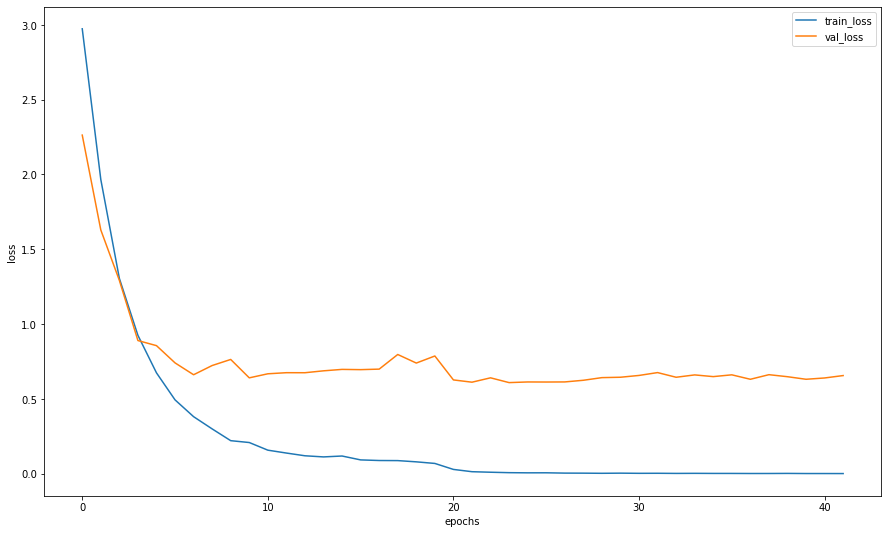

In [10]:
history = train(train_dataset, val_dataset, model=clf, epochs=EPOCHS, batch_size=BATCH_SIZE)
    
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

###  Submission

In [14]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
submit = pd.DataFrame(columns=['Id', 'Expected'])
test_dataset = SimpsonsDataset(test_files, mode="test")
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
probs = predict(clf, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))    
submit['Expected'] = preds
submit.to_csv('./out/PROD_custom_adamw_lrp3.csv', index=False)
submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
